## Sinusoidal time series with Gaussian Noise: statistical properties 

We generate the time series:  $x(t) = A \sin{(t)} + 1 + \mathcal{N}(0,\sigma_{0})$. $data = model  + noise $
    
We fix $\sigma_{0} = 0.1$, $N_{points} = 100$, and make use of the AstroML 5.8 code $10^{4}$ times. At each iteration calculate :

* $\chi^{2}_{DOF} = \frac{1}{N}  \sum((x_{i} - 1  ) /  \sigma_{0})^{2}$
* mean : $\langle \sigma_{int} \rangle = \frac{\sum \sigma p(\sigma_{int})}{\sum p(\sigma_{int})}  $ 
* standard deviation : stdev($\sigma_{int}$) = $\left(\frac{\sum \sigma_{int}^{2}p(\sigma_{int}) } {\sum p(\sigma_{int})} - \langle \sigma_{int} \rangle^{2} \right) ^{1/2}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF
import os 
import datetime
import imp
imp.reload(varF)

<module 'variabilityFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/variabilityFunctions.py'>

In [212]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_chi_SN_compare/', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
    
print('Today we save all figure data in: %s '%outDir)

Today we save all figure data in: /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi_SN_compare/2017-02-17/ 


## 1000 iterations loop

This is the calculation loop; it takes about 10 minutes to run on a Mac , save time by loading the results of  the most recent calculation 

In [431]:
# The general structure testing : 

A_keys =[round(value,4) for value in A_values]

A_keys = A_keys[:10]

N_iterations = 5

store_xi_ei = {}
# Multi-nested dictionary : 
#store_xi_ei[Amplitude][Iteration] = {'xi', 'ei', 'sigma_int', 'p_sigma_int'}

for j in range(len(A_keys)) : 
    store_xi_ei[A_keys[j]] = {}
    
    for k in range(N_iterations):
        # initiate the the storage dictionary for this iteration...
        store_xi_ei[A_keys[j]][k] = {}
        store_xi_ei[A_keys[j]][k]['xi'] = np.arange(10) * k

In [210]:
%matplotlib inline

N_pts = 100.0  # number of points in time series  
Nboot = 1000  # number of bootstraps 
# A_values = np.linspace(0.01, 1, 100) 
A_values = np.linspace(0.01, 2, 200) # 200   # [0.01, 0.1, 0.7,1.0]   
sigma_0 = 1.0  # the standard deviation of Gaussian distribution from which we source homoscedastic errors 
N_iterations = 1000  # number offsave times we realize time series, calculating chi2,  and properties of p(sigma)
                 #  at each realization 

# sigma = [1.0] # [0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 0.3, 0.5, 1]
# that is 0.1%,  0.5%, 1%, 2%, 3%, 5% 

# counter for printing pictures in order 
i = 0

# initialize the time array : only one period of the sinusoid 
t = np.linspace(0,2*np.pi, num=N_pts)

stats = {}  # array to store values 

# an array of keys, to have control over the quality of floats used for indexing 
# http://stackoverflow.com/questions/23721230/float-values-as-dictionary-key 
A_keys =[round(value,4) for value in A_values]

# initialize a dictionary to store time series
# at each iteration.... 
store_xi_ei = {}

for j in range(len(A_values)) : 
    print(' A value is %f' % A_values[j])
    stats[A_keys[j]] = {}
    stats[A_keys[j]]['iteration_number'] = np.arange(N_iterations)
    # time series first order stats... 
    stats[A_keys[j]]['chi2dof']          = np.zeros(N_iterations)
    # results of full calculation
    stats[A_keys[j]]['sigma_lnL_max'] = np.zeros(N_iterations)
    stats[A_keys[j]]['mu_lnL_max'] = np.zeros(N_iterations)
    # pdf stats
    stats[A_keys[j]]['sigma_max_pdf'] = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_mean_sigma']   = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_median_sigma'] = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_stdev_sigma']  = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_sigmaG']       = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_probTwoStDev'] = np.zeros(N_iterations)
    stats[A_keys[j]]['pdf_GaussLike']    = np.zeros(N_iterations)
    
    A = A_values[j]
    
    # need for each value of amplitude to store N_iterations of values of xi, ei  :
    # use a dictionary 
    store_xi_ei[A_keys[j]] = {}
    
    for k in range(N_iterations):
        
        # initiate the the storage dictionary for this iteration...
        store_xi_ei[A_keys[j]][k] = {}
        
        # define the time series 
        noise = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 
        xi = A* np.sin(t) + 1 + noise
        ei = np.ones_like(xi) * sigma_0 
        
        # save the time series per iteration... 
        store_xi_ei[A_keys[j]][k]['xi'] = xi
        store_xi_ei[A_keys[j]][k]['ei'] = ei
        
        pdf_stats, plot_data, mu_max, sigma_max = varF.get_mu_sigma(xi,ei, N_boot=Nboot, 
                                                           return_plot_data=True, return_sigma_pdf_info = True)
        
        # save the values that I would claim as the 'sigma_0', or 'mu_0',  
        # used for all SF plots where I say I use results of 
        # 'full calculation...' 
        
        stats[A_keys[j]]['sigma_lnL_max'][k] = sigma_max
        stats[A_keys[j]]['mu_lnL_max'][k] = mu_max
        
        # load pdf, and the grid, from the routine... 
        p_sigma = plot_data['p_sigma'] 
        sigma_int = plot_data['sigma']
        
        # sigma at the 1D  maximum of the pdf 
        sigma_1D_max = sigma_int[p_sigma == max(p_sigma)][0]
        stats[A_keys[j]]['sigma_max_pdf'][k] = sigma_1D_max
        
        # store stuff for this iteration....
        store_xi_ei[A_keys[j]][k]['p_sigma'] = p_sigma
        store_xi_ei[A_keys[j]][k]['sigma'] = sigma_int
        
        # store the slice of logL along  maximum value of mu... 
        logL = plot_data['logL']
        ind = np.where(logL == np.max(logL))
        sig_max_index, mu_max_index = ind[0][0], ind[1][0]  # extract the row, column where 2D max of logL is located
        logL_slice = logL[:,mu_max_index]  # take all values of logL along mu_max columns
        p_sigma_slice = np.exp(logL_slice)  # calculate raw pdf  
        p_sigma_slice /= (sigma[1] - sigma[0]) * p_sigma_slice.sum() # normalize the pdf 
        store_xi_ei[A_keys[j]][k]['p_sigma_slice'] = p_sigma_slice
 
        # calculate chi2 
        data  = xi
        model = 1
        error = sigma_0
        chi_sq_dof = np.sum(((data - model)/ error)**2.0) / N_pts  
        
        # store in a dictionary
        stats[A_keys[j]]['chi2dof'][k]       = chi_sq_dof
        
        # save the pdf stats from built-in routine
        stats[A_keys[j]]['pdf_mean_sigma'][k]   = pdf_stats['mean']
        stats[A_keys[j]]['pdf_median_sigma'][k] = pdf_stats['median']
        stats[A_keys[j]]['pdf_stdev_sigma'][k]  = pdf_stats['stdev']
        stats[A_keys[j]]['pdf_sigmaG'][k]       = pdf_stats['sigmaG']
        stats[A_keys[j]]['pdf_probTwoStDev'][k] = pdf_stats['probInTwoStdev']
        stats[A_keys[j]]['pdf_GaussLike'][k]    = pdf_stats['GaussLike']

        i += 1 
print('finished')

 A value is 0.010000
 A value is 0.020000
 A value is 0.030000
 A value is 0.040000
 A value is 0.050000
 A value is 0.060000
 A value is 0.070000
 A value is 0.080000
 A value is 0.090000
 A value is 0.100000
 A value is 0.110000
 A value is 0.120000
 A value is 0.130000
 A value is 0.140000
 A value is 0.150000
 A value is 0.160000
 A value is 0.170000
 A value is 0.180000
 A value is 0.190000
 A value is 0.200000
 A value is 0.210000
 A value is 0.220000
 A value is 0.230000
 A value is 0.240000
 A value is 0.250000
 A value is 0.260000
 A value is 0.270000
 A value is 0.280000
 A value is 0.290000
 A value is 0.300000
 A value is 0.310000
 A value is 0.320000
 A value is 0.330000
 A value is 0.340000
 A value is 0.350000
 A value is 0.360000
 A value is 0.370000
 A value is 0.380000
 A value is 0.390000
 A value is 0.400000
 A value is 0.410000
 A value is 0.420000
 A value is 0.430000
 A value is 0.440000
 A value is 0.450000
 A value is 0.460000
 A value is 0.470000
 A value is 0

1000

In [218]:
# Save all the xi,ei ...
np.save(outDir+'Amplitude_iter_xi_ei.npy', store_xi_ei)

# Saved the parameters used for the simulation
params = {'N_pts' :N_pts, 'N_bootstraps':Nboot, 'sigma_0' : sigma_0, 
          'N_iterations': N_iterations, 'A_keys':A_keys } 
fname = 'simulation_save_params.npy'
np.save(outDir+fname, params) 

# Save the results of calculation for future plotting...
fname = 'simulation_save_A_chi2_stdev_mean.npy'
np.save(outDir+fname, stats) 





In [219]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi_SN_compare/2017-02-17/'

## Reading the results 

If this has been done before: save time, just load the most recent results....

In [3]:
outDir = '/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi_SN_compare/2017-02-17/'
print('Using results from %s'% outDir)

# Load the results of calculation ... 
fname = 'simulation_save_A_chi2_stdev_mean.npy'
saved_stats = np.load(outDir+fname).item()

#saved.keys()  # these are values of amplitude , sampled between 0.01 and 1 

# Load the parameters used for the calculation...
fname = 'simulation_save_params.npy'
params = np.load(outDir+fname).item()
N_pts = params['N_pts']


# Load the xi, ei ....
saved_xi_ei = np.load(outDir+'Amplitude_iter_xi_ei.npy').item()


Using results from /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi_SN_compare/2017-02-17/


In [10]:
# Need to make the dictionary keys ....

A_values = np.linspace(0.01, 2, 200)
A_keys =[round(value,4) for value in A_values]


## Plot : histogram of  $\chi^{2}_{DOF}$ and $S/N$

In [11]:
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 20



In [222]:
N

dict_keys(['mu_lnL_max', 'sigma_max_pdf', 'pdf_stdev_sigma', 'iteration_number', 'pdf_mean_sigma', 'pdf_median_sigma', 'pdf_GaussLike', 'chi2dof', 'pdf_probTwoStDev', 'pdf_sigmaG', 'sigma_lnL_max'])

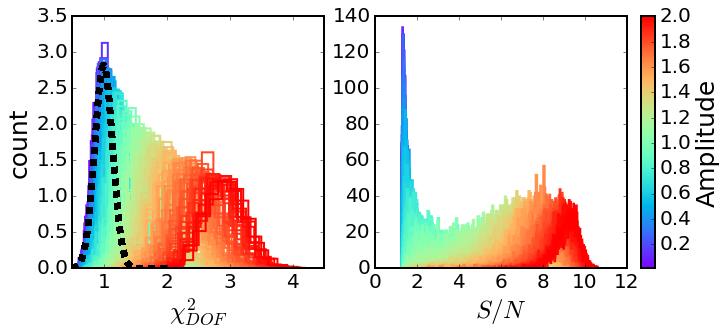

In [12]:
# plot the histogram of chi2dof 
import matplotlib
%matplotlib inline
from matplotlib.pyplot import cm 


# define signal-to-noise.... 
signal = 'pdf_mean_sigma' 
noise = 'pdf_stdev_sigma'


##### WANT TO CONTROL EXACTLY THE RATIO OF AXES, AND HAVE SPACE FOR COLORBAR, ETC.  

# A GRID SPEC SOLUTION  
#import matplotlib.gridspec as gridspec
#fig = plt.figure(figsize=(11,5 ))
#ax = dict()
# gridspec.GridSpec(number_of_rows,  number_of_columns)
#gs = gridspec.GridSpec(10,11)
# ax = plt.subplot(gs[rowspan, colspan])
#ax[0] = plt.subplot(gs[:9, :5])  # span all rows but the last one (bottom), and first 5 cols 
#ax[1] = plt.subplot(gs[:9, 5:10])  # span all rows but the last one (bottom), and last 5 cols 
#ax[2] = plt.subplot(gs[0, 10])  # span both rows, only second col 

# A FIG ADD_AXES  SOLUTION 
# manually fudging all the quantities here we arrive at the good configuration
# by visually inspecting the output figure ...


fig = plt.figure(figsize=(10,5 ))
ax = dict()

# AXIS 1 
# Add an axes at position rect [left, bottom, width, height] 
# all quantities are in fractions of figure width and height.
x0 = 0.1 ; y0 =0.2 ; dx = 0.35 ; dy = 0.7
ax[0] = fig.add_axes([x0, y0, dx, dy])

# AXIS 2
wspace=0.07
x1 = x0 + dx + wspace  
y1 = y0 
ax[1] = fig.add_axes([x1, y1, dx, dy])

# AXIS 3 : COLORBAR  
x0 = 0.89 ; dx = 0.02
colorbar_ax = fig.add_axes([x0, y0, dx, dy])

# A STANDARD SOLUTION : WHY WOULDN'T IT WORK ? 

# limit on which A we plot : only go up to A=2 
# 
#A_array = np.array(A_keys)
#A_chosen = A_array[A_array < 2.02]

# Colored lines... 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(vmin=np.min(A_keys),vmax=np.max(A_keys))

# choose a colormap
c_m = cm.rainbow

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


colors=cm.rainbow(np.linspace(0,1,len(A_keys)))

for A in A_keys :   ## A_keys
    bins = np.linspace(0.5,2,100)
    sigma  = np.sqrt(2/N_pts)  # theory spread of chi2 for that many points
    mu = 1  # theory mean of the data 
    import gc ; gc.collect()
    
    ax[0].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
               lw=6, color='black', ls='--', alpha=0.5) # overplotting Gaussian curve 
    ax[0].hist(saved_stats[A]['chi2dof'], histtype='step', label='A='+str(A), 
               color = s_m.to_rgba(A), normed=True, lw=2)  # chi2 
    
    m = np.isnan(saved_stats[A][signal]) * np.isnan(saved_stats[A][noise])
    
    ax[1].hist(saved_stats[A][signal][~m] / saved_stats[A][noise][~m], histtype='step', 
               label='A='+str(A),color = s_m.to_rgba(A), lw=2, bins=100)  # S/N 
    ax[0].set_ylabel('count')
    ax[0].set_xlabel(r'$\chi^{2}_{DOF}$')
    ax[1].set_xlabel(r'$S/N$')

xticks = ax[0].get_xticks()
ax[0].set_xticks(xticks[1::2])

    
cbar = fig.colorbar(s_m, ax=ax[1], cax=colorbar_ax)
cbar.set_label('Amplitude')
#plt.tight_layout()
plt.savefig(outDir + 'Fig_1_chi_SN_histograms_lim_2.png')

## Stack the results:  saved_stats[A][params...] -->  plot_data[A,params...]

In [13]:
#Stack the stats , and find out if I can correctly retrieve xi, ei for a particular iteration... 

plot_data = {'chi2dof':np.zeros(0, dtype=float), 'SN':np.zeros(0, dtype=float),
            'A':np.zeros(0, dtype=float), 'N_iter' : np.zeros(0, dtype=float),
            'pdf_mean_sigma':np.zeros(0, dtype=float),  'pdf_stdev_sigma':np.zeros(0, dtype=float),
            'pdf_sigmaG':np.zeros(0, dtype=float), 'sigma_lnL_max':np.zeros(0, dtype=float),
            'sigma_max_pdf':np.zeros(0, dtype=float)}


# loop over values of amplitude

# 1) grab all chi2 and SN valus for a given  amplitude 
# 2) throw away all those values outside of the desired bounds for the scatter plot 
# 3) append chi2, SN, and A value to the new structure where each row represents and individual iteration 
#   --> thus we are choosing rows from 100 * 1000 available

signal = 'pdf_mean_sigma' 
noise = 'pdf_stdev_sigma'

transfer = ['pdf_mean_sigma','pdf_stdev_sigma' ,'pdf_sigmaG','sigma_lnL_max','sigma_max_pdf']
for A in A_keys : 
    
    SN = saved_stats[A][signal] / saved_stats[A][noise]
    chi2 =  saved_stats[A]['chi2dof']
    N_iter  = saved_stats[A]['iteration_number']
    
    plot_data['SN'] = np.append(plot_data['SN'], SN)
    plot_data['A']  = np.append(plot_data['A'], np.ones_like(SN) * A)
    plot_data['N_iter'] = np.append(plot_data['N_iter'], N_iter)
    plot_data['chi2dof'] = np.append(plot_data['chi2dof'], chi2)
    for key in transfer : 
        plot_data[key] = np.append(plot_data[key], saved_stats[A][key])


## Plot : completeness curve ..

Given A, we calculate what fraction is above a certain $S/N$ : choose $S/N=3$ or $5$ to make two completeness curves : plot of completeness vs $A/\sigma$
Completeness is defined as a fraction of all runs that are above a given $S/N$.

In [14]:
frac = {}
SN_cuts = [3,5]
for SN_cut in SN_cuts :  # choose which completeness curve 
    frac[SN_cut] = np.zeros(len(A_values))
    i = 0 
    for A in A_keys :  # for each A, calculate fraction greater than given SN 
        
        SN = saved_stats[A]['pdf_mean_sigma'] / saved_stats[A]['pdf_stdev_sigma']
        #print(len(SN))
        frac[SN_cut][i] = np.sum(SN > SN_cut) / float(len(SN))
        i += 1

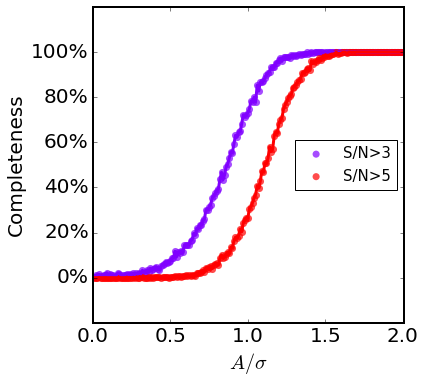

In [15]:
fig,ax = plt.subplots(figsize = (6,5.4))
colors=cm.rainbow(np.linspace(0,1,len(SN_cuts)))
for SN_cut, color in zip(SN_cuts,colors) : 
    ax.scatter(A_values, frac[SN_cut], label = 'S/N>'+str(SN_cut), lw=0, color=color, alpha=0.7, s=50)
    ax.plot(A_values, frac[SN_cut], color=color, lw=3)
ax.set_xlabel(r'$A / \sigma$', fontsize=20)
ax.set_ylabel('Completeness', fontsize=20)
ax.set_xlim(0,2.01)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
ax.legend(loc='center right',scatterpoints=1, fontsize=15 )
plt.tight_layout()

plt.savefig(outDir + 'Fig_2_Completeness_curve_lim_2.png')

## Plot:  $\chi^{2}_{DOF}$ vs $S/N$ : Scatter plot .... 

According to chapter 10.1.1, the minimum detectable amplitude for a time series $y = A sin(\omega t)$ sampled by N points, with homoscedastic Gaussian errors with standard deviation $\sigma$, is  $A_{min} = 2.9 \sigma / N^{1/4}$.

For the simulation above, N=100,  $\sigma=1.0$, so:

In [16]:
print('A_min = %f'%(2.9 / np.power(100,0.25)))

A_min = 0.917061


The standard deviation for $\chi^{2}$ distribution is $\sigma = \sqrt{(2/N)}$. For $N=100$, $\sigma = 0.14$, so that $1+3 \sigma = 1.42$, and $1+5\sigma=1.70$. On the scatter plot below of S/N vs $\chi^{2}_{DOF}$ we mark $3 \sigma$ and $5 \sigma$ levels by horizontal dashed lines.  

    A_keys : array of 100 values of amplitude , sampled from 0.01 to 1 
    
For each A we make 1000 realizations of time series with N=100 points.  For each realization, we calculate the AstroML 5.8 $\sigma$, as well as properties of the PDF : $p(\sigma)$, that yields $S/N$ for each time series.  We also calculate for each realization the value of $\chi^{2}_{DOF}$ against the hypothesis of no variability (model y=1 ) .  

The aim is to compare how does $\chi^{2}_{DOF}$ compare to $S/N$ in selecting variable objects for a given (input) amplitude. Since for each A we have 1000 realizations of time series, we can plot the histogram of $\chi^{2}_{DOF}$ or $S/N$ , which is done in figure above.  

Below we plot $\chi^{2}_{DOF}$ vs $S/N$  as a scatter plot.  The points can be binned, and colored by various properties : eg. count of points in a given $\chi^{2}_{DOF}$ - $S/N$ bin,  or some other property (eg. mean amplitude of points in that bin , etc. , using binned_statistic_2d  )  



We chose 200000 out of 200000 total rows for plotting 
That is, 100.000 % of data


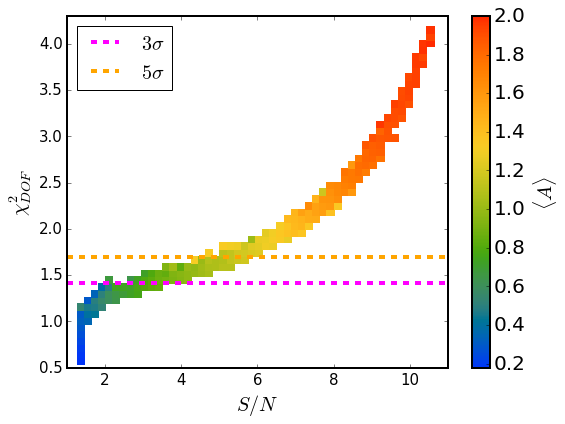

In [37]:
# SN limits 
x_min = 0.1
x_max = 12

# chi2dof limits 
y_min = 0
y_max = 10


# loop over values of amplitude

# 1) grab all chi2 and SN valus for a given  amplitude 
# 2) throw away all those values outside of the desired bounds for the scatter plot 
# 3) append chi2, SN, and A value to the new structure where each row represents and individual iteration 
#   --> thus we are choosing rows from 100 * 1000 available

#mask_chi = (saved_stats[A]['chi2dof'] > y_min ) *(saved_stats[A]['chi2dof'] < y_max)
#SN = saved[A][signal] / saved[A][noise]
#mask_SN  = (SN > x_min) * (SN < x_max)
#mask_comb = mask_chi * mask_SN
#chi2 =  saved[A]['chi2dof'][mask_comb]
#SN = SN[mask_comb]
    
    
N_chosen = len(plot_data['SN'])
N_total = params['N_iterations'] * len(A_keys)
print('We chose %d out of %d total rows for plotting '%(N_chosen, 
                                                        N_total))
print('That is, %.3f %% of data'%(100*N_chosen / N_total))

# the 2D binned_statistic histograms are inspired by work in VarStat_exploratory_ugriz_results.ipynb  
from scipy.stats import binned_statistic_2d

fig,ax = plt.subplots(figsize=(8,6))

stats = binned_statistic_2d(x=plot_data['SN'], y=plot_data['chi2dof'], 
                            values = plot_data['A'], statistic='mean', bins=50)
    
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
cmap = ListedColormap(cc.rainbow)
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cmap)  # np.log10(z_masked) gives log counts 
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.tick_params(axis='both', which='major', labelsize=15) 
#ax.set_xlim(0,2)
#ax.set_ylim(0,.08)
ax.set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=20)
ax.set_xlabel(r'$S/N$', fontsize=20)

# horizontal lines for 3 sigma and 5 sigma levels... 
style = '--'
width = 4
color = 'magenta'
ax.axhline(1.42, lw=width, ls=style, c='magenta', label=r'$3 \sigma$')
ax.axhline(1.70, lw=width, ls=style, c='orange', label=r'$5 \sigma$')
ax.set_ylim(0.5,4.3)
ax.set_xlim(1,11)
plt.legend(loc='upper left', fontsize=20)
#ax.set_title(r'$$', fontsize=20)
#colorbar_ax = fig.add_axes([0.2, 0.86, 0.4, 0.01])
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$\langle A \rangle$', fontsize=20)
plt.tight_layout()
plt.savefig(outDir+'Fig_3_chi_SN_scatter.png')


NOTE : above we used $\verb|statistic='count'|$ .  There is nothing that would make it hard to use $\verb|statistic='mean'|$  (mean Amplitude per bin), or anything else... 

## Investigate S/N around 1.5 and 5.0 ... 

### Use saved_xi_ei  if reading in a result....

In [259]:
plot_data.keys()

dict_keys(['sigma_max_pdf', 'SN', 'sigma_lnL_max', 'pdf_stdev_sigma', 'pdf_mean_sigma', 'chi2dof', 'A', 'pdf_sigmaG', 'N_iter'])

We have 27520  iterations fulfilling these criteria
We have very low SN for A=0.010000, iteration number 28
For this iteration, chi2dof = 0.868645, 
sig_max = 0.000000, mean = 0.181051, stdev = 0.134064, SN = 1.350480


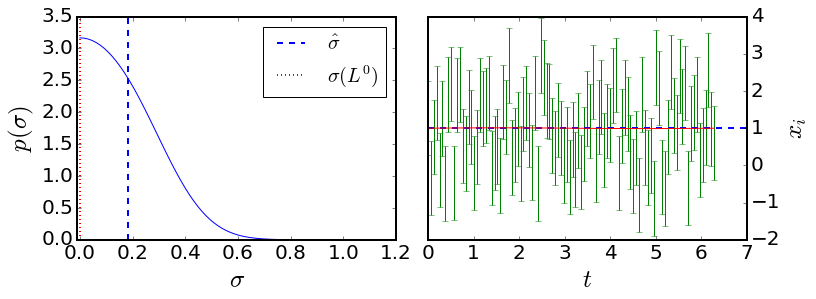

In [237]:
import gc ; gc.collect()


# set any conditions you want, to find some interesting pdf ....

pick_SN_around_5 = False
if pick_SN_around_5 == True : 
    max_SN = plot_data['SN'] < 5.1
    min_SN = plot_data['SN'] > 5.0
    mask = max_SN * min_SN

pick_low_SN = True
if pick_low_SN == True : 
    low_SN = plot_data['SN'] < 1.5 
    low_chi2 = plot_data['chi2dof'] < 1.5
    mask= low_SN * low_chi2 

# NOTE : all those that have SN < 1.3,  and chi2 < 1.5,  have sigma_max = 0 
# but already if I relax SN < 1.5, chi2 < 1.5, there are a few that have nonzero sigma_max 


print('We have %d  iterations fulfilling these criteria'%np.sum(mask))

i = 14

A = plot_data['A'][mask][i]
N = int(plot_data['N_iter'][mask][i])
chi2dof = plot_data['chi2dof'][mask][i]

print('We have very low SN for A=%f, iteration number %d'%(A,N))
print('For this iteration, chi2dof = %f, ' % chi2dof)
mean  = plot_data['pdf_mean_sigma'][mask][i]  #saved_stats[A]['pdf_mean_sigma'][N]
stdev = plot_data['pdf_stdev_sigma'][mask][i] #saved_stats[A]['pdf_stdev_sigma'][N]
SN    = plot_data['SN'][mask][i]
sig_max = plot_data['sigma_lnL_max'][mask][i]

print('sig_max = %f, mean = %f, stdev = %f, SN = %f'%(sig_max, mean,stdev,SN))

sigma = saved_xi_ei[A][N]['sigma']
p_sigma = saved_xi_ei[A][N]['p_sigma']



# read the time series and pdf shape from saved_xi_ei()
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(sigma,p_sigma)
ax[0].axvline(mean, lw=2, ls='--', label=r'$\hat{\sigma}$')
#ax[0].axvline(saved_xi_ei[A]['pdf_median_sigma'][N], lw=2, ls='-.', label=r'$med(\sigma)$')
ax[0].axvline(sig_max, lw=2, ls=':', color='red', label=r'$\sigma(L^{0})$')
ax[0].set_xlim(-0.01)
ax[0].legend(fontsize=20)
ax[0].set_xlabel(r'$\sigma$')
ax[0].set_ylabel(r'$p(\sigma)$')

xi = saved_xi_ei[A][N]['xi']
ei = saved_xi_ei[A][N]['ei']
t  = np.linspace(0,2*np.pi, num=100)

ax[1].plot(t,xi, lw=0)
ax[1].errorbar(t,xi,ei, ls='')
ax[1].axhline(1,lw=2, ls='--')
ax[1].plot(t, A*np.sin(t)+1)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$x_{i}$')

fig.subplots_adjust(wspace=0.1)
figname = 'Fig_6_pdf_A-'+str(A).zfill(0) +'_iter-'+str(N)+'_chi2-'+str(chi2dof.round(4))+'_SN-'+str(SN.round(4))+'.png'
plt.savefig(outDir+figname)

## Illustrate what is meant by  a slice of $L$ along $\mu_{max}$:

In [276]:
imp.reload(varF)

<module 'variabilityFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/variabilityFunctions.py'>

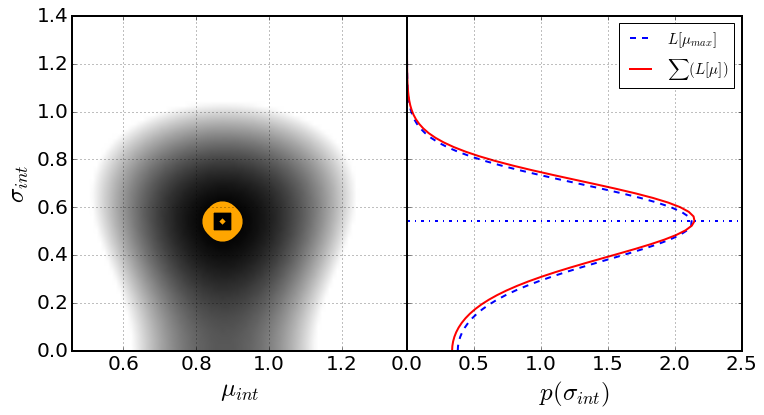

In [277]:


# remove closed figures ...
import gc ; gc.collect()# Show how slicing works...

N_pts = 100.0  # number of points in time series  
Nboot = 1000  # number of bootstraps 
# A_values = np.linspace(0.01, 1, 100) 
A_values = np.linspace(0.01, 2, 200) # 200   # [0.01, 0.1, 0.7,1.0]   
sigma_0 = 1.0  # the standard deviation of Gaussian distribution from which we source homoscedastic errors 
t = np.linspace(0,2*np.pi, num=N_pts)

# define the time series 
noise = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 

# choose which value of A we'd like to plot ...
A  = A_values[67]
xi = A* np.sin(t) + 1 + noise
ei = np.ones_like(xi) * sigma_0 

      
    
pdf_stats, plt_data, mu_max, sigma_max = varF.get_mu_sigma(xi,ei, N_boot=Nboot, sigma_gridsize=70, mu_gridsize=80,
                                                           return_plot_data=True, return_sigma_pdf_info = True)



%matplotlib inline
logL = plt_data['logL']

L = np.exp(logL)
sigma = plt_data['sigma']

mu = plt_data['mu']
p_sigma = L.sum(1)
# normalize... 
p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum() 

# sigma at the maximum value of the pdf 
sigma_1D_max = sigma[p_sigma == max(p_sigma)][0]


# plot logL
fig,ax = plt.subplots(1,2, figsize=(12,6), sharey=True)

im = ax[0].imshow(logL, origin='lower',
            extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto', vmin=-5, vmax=0)
ind = np.where(logL == np.max(logL))

sig_max_index, mu_max_index = ind[0][0], ind[1][0]
logL_slice = logL[:,mu_max_index]
sigma_2D_max = sigma[sig_max_index]

p_sigma_slice = np.exp(logL_slice)
p_sigma_slice /= (sigma[1] - sigma[0]) * p_sigma_slice.sum() 
ax[0].scatter(mu[ind[1]][0], sigma[ind[0]][0], marker='D', color='orange', lw =34)
#plt.clim(-4, 0)
ax[0].set_xlabel(r'$\mu_{int}$')
ax[0].set_ylabel(r'$\sigma_{int}$')

ax[1].plot(p_sigma_slice,sigma, color='blue', ls='--', label=r'$L[\mu_{max}]$', lw=2)
ax[1].plot(p_sigma, sigma, color='red', label=r'$\sum(L[\mu])$', lw=2)
ax[1].axhline(sigma_1D_max, color='red', ls='-.', lw=2)
ax[1].axhline(sigma_2D_max, color='blue', ls='-.', lw=2)
ax[1].legend(fontsize=15)
#ax[1].set_ylabel(r'$\sigma$')
ax[1].set_xlabel(r'$p(\sigma_{int})$')
ax[0].grid()
ax[1].grid()
fig.subplots_adjust(wspace=0)
figname = 'Fig_7_simulation_A_'+str(A)[:5]+'_L_1D_2D_maxima.png'
plt.savefig(outDir+figname)

Red curve is what we would call 'marginalized' distribution of $\sigma_{int}$ along $\mu_{int}$ : 
    
$p(\sigma_{int}) = \int L(\mu_{int}, \sigma_{int}) d \mu_{int}$
    
For this reason I rotated the axis of the right panel by $90 \deg$ to show that indeed the red curve is a 2D projection of the 3D likelihood space  ($\mu$  x  $\sigma$ x  value) .  The horizontal dot-dashed red line shows the value of $\sigma_{int}$ at the 1D  maximum  of such marginalized $p(\sigma_{int})$. 

Blue dashed curve is the slice through  likelihood space across $\mu_{int} = \mu_{2Dmax}$. The green dot-dashed line is the value of $\sigma_{int}$ at the 2D maximum of likelihood space. 

## Compare 1D and 2D maxima of pdf 

In [262]:
plot_data.keys()

dict_keys(['sigma_max_pdf', 'SN', 'sigma_lnL_max', 'pdf_stdev_sigma', 'pdf_mean_sigma', 'chi2dof', 'A', 'pdf_sigmaG', 'N_iter'])

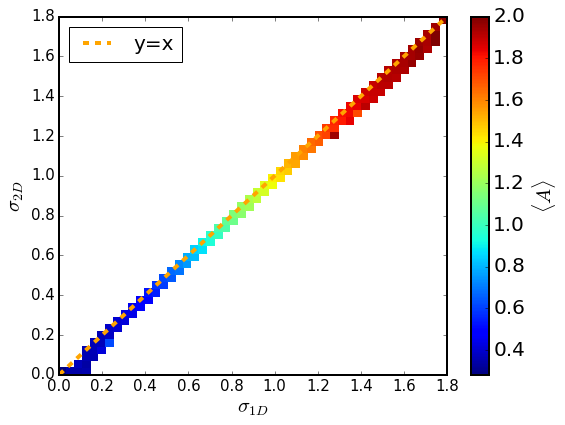

In [271]:
from scipy.stats import binned_statistic_2d
import gc ; gc.collect()

fig,ax = plt.subplots(figsize=(8,6))

stats = binned_statistic_2d(x=plot_data['sigma_max_pdf'], y=plot_data['sigma_lnL_max'], 
                            values = plot_data['A'], statistic='mean', bins=50)
    
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap='jet')  # np.log10(z_masked) gives log counts 
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.tick_params(axis='both', which='major', labelsize=15) 
#ax.set_xlim(0.6,4.2)
#ax.set_ylim(0.5,2)
ax.set_xlabel(r'$\sigma_{1D}$', fontsize=20)
ax.set_ylabel(r'$\sigma_{2D}$', fontsize=20)
x = np.linspace(0,1.8)
ax.plot(x,x,ls='--', lw=4, color='orange', label='y=x')
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$\langle A \rangle$', fontsize=20)
ax.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.savefig(outDir+'Fig_X_sigma_1D_vs_2D.png')



## Illustrating eq. 10.57, and 10.1.1 : minimum detectable amplitude 

As proved in my Variability Detection write-up,  if we consider a harmonic time-series, $y = A sin(\omega t)$ , for which the variance is $V = A^{2}/2 + \sigma^{2}$,  and $\chi^{2}_{DOF,series} = V / \sigma^{2}$ .  If we want to distinguish a time-series from noise, we  may 
    
a) require that it's $\chi^{2}_{DOF,series}$ has at least $3\sigma$ departure from pure noise ($\chi^{2}_{DOF,noise} = 1$ ),  so that we have :
$\chi^{2}_{DOF,series} =  V / \sigma^{2} = 1 +3 \sqrt{2/N}$, we find that :
  * $A_{min} /\sigma = 2.9 / N^{1/4}$

b) require that the $\Delta BIC = BIC_{series} - BIC_{noise} > 10$, so that (from eq. 10.57 and the proof in my Variability Detection write-up):
  * $A_{min}/\sigma = \left( \frac{6 \ln {N} + 20 }{N} \right) ^ {1/2}$
  
c) require that the $\Delta AIC = AIC_{series} - AIC_{noise} > 10$, so that : 
  * $A_{min} / \sigma = \sqrt{32/N}$

these three requirements are visualized on a plot below : 



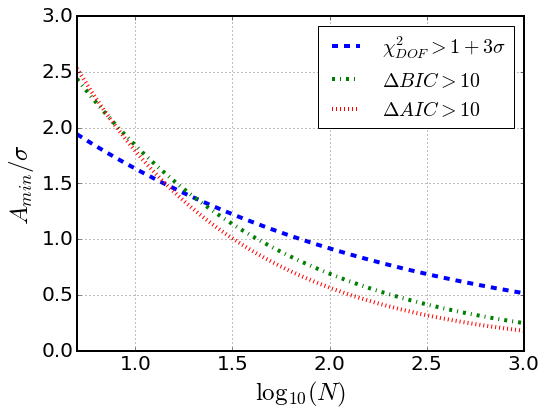

In [272]:
N = np.linspace(5,1001,1000)
fig,ax = plt.subplots(figsize=(8,6))
width = 4
ax.plot(np.log10(N), 2.9 / np.power(N,0.25), lw=width,ls= '--',label=r'$\chi^{2}_{DOF} >  1 + 3\sigma $')
ax.plot(np.log10(N), np.sqrt((6 * np.log(N)+20)/(N)), ls='-.',lw=width, label=r'$\Delta BIC > 10$')
ax.plot(np.log10(N), np.sqrt(32/N), lw=width, ls = ':', label=r'$\Delta AIC > 10$')
ax.set_ylabel(r'$A_{min}/\sigma$')
ax.set_xlabel(r'$\log_{10}{(N)}$')
ax.tick_params(axis='both', which='major') 
#ax.set_title('Minimum A/$\sigma$ to detect periodicity ', fontsize=15)
ax.set_xlim(0.7,3)
plt.legend(fontsize=20)
ax.grid()
plt.savefig(outDir+'Fig_4_min_det_amplitude.png')

## Additional plots: sanity check. $\chi^{2}$ vs $A$ and $S/N$ vs $A$. 

It would be all very narrow, since we have one value of $A$ per 1000 values of $\chi^{2}$ : 

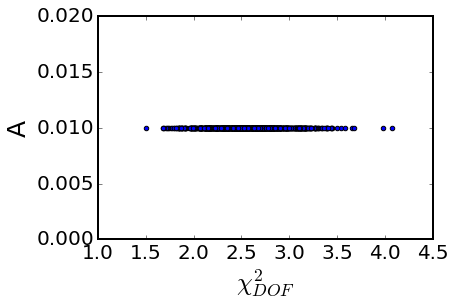

In [673]:
plt.scatter(saved_stats[A_keys[0]]['chi2dof'], A_keys[0]*np.ones_like(saved_stats[A_keys[0]]['chi2dof']) )
plt.xlabel(r'$\chi^{2}_{DOF}$')
plt.ylabel('A')

, so just for plotting we randomize A by adding $\mathcal{N}(0,0.005)$ :

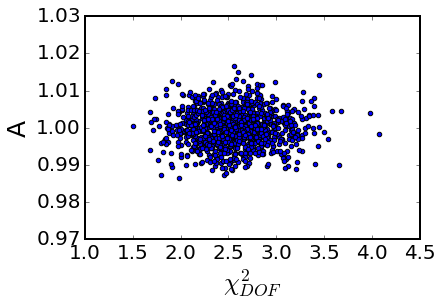

In [674]:
plt.scatter(saved_stats[A_keys[0]]['chi2dof'],np.random.normal(0,0.005, 1000 )+ np.ones_like(saved_stats[A_keys[0]]['chi2dof']) )
plt.xlabel(r'$\chi^{2}_{DOF}$')
plt.ylabel('A')

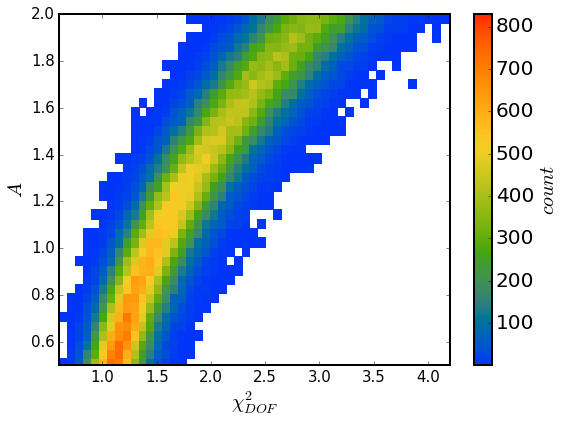

In [25]:
from scipy.stats import binned_statistic_2d
import gc ; gc.collect()

fig,ax = plt.subplots(figsize=(8,6))

stats = binned_statistic_2d(x=plot_data['chi2dof'], y=plot_data['A'], 
                            values = plot_data['A'], statistic='count', bins=50)
cmap = ListedColormap(cc.rainbow)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cmap)  # np.log10(z_masked) gives log counts 
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.tick_params(axis='both', which='major', labelsize=15) 
ax.set_xlim(0.6,4.2)
ax.set_ylim(0.5,2)
ax.set_xlabel(r'$\chi^{2}_{DOF}$', fontsize=20)
ax.set_ylabel(r'$A$', fontsize=20)

colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=20)

plt.tight_layout()
plt.savefig(outDir+'Fig_4_A_vs_chi2dof.png')


In [ ]:
cc.

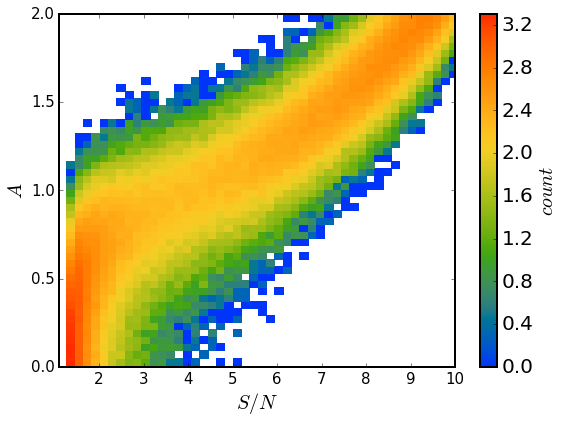

In [29]:
import colorcet as cc
from matplotlib.colors import ListedColormap
cmap = ListedColormap(cc.rainbow) # 'coolwarm'  # 

fig,ax = plt.subplots(figsize=(8,6))

m = np.isnan(plot_data['SN'])
stats = binned_statistic_2d(x=plot_data['SN'][~m], y=plot_data['A'][~m], 
                            values = plot_data['sigma_lnL_max'][~m], statistic='count', bins=50)



z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,np.log10(z_masked), cmap=cmap)  # np.log10(z_masked) gives log counts 
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.tick_params(axis='both', which='major', labelsize=15) 
ax.set_xlim(1.1,10)
ax.set_ylim(0,2)
ax.set_xlabel(r'$S/N$', fontsize=20)
ax.set_ylabel(r'$A$', fontsize=20)

colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=20)

plt.tight_layout()
plt.savefig(outDir+'Fig_4_A_vs_SN.png')



In [680]:
plot_data.keys()

dict_keys(['SN', 'chi2dof', 'A', 'N_iter'])

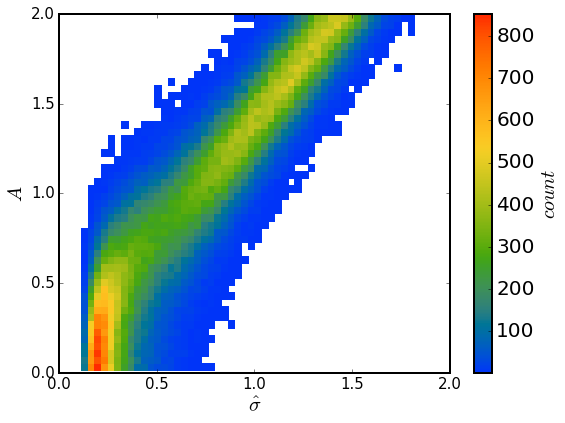

In [28]:
fig,ax = plt.subplots(figsize=(8,6))

m = np.isnan(plot_data['pdf_mean_sigma'])
stats = binned_statistic_2d(x=plot_data['pdf_mean_sigma'][~m], y=plot_data['A'][~m], 
                            values = plot_data['chi2dof'][~m], statistic='count', bins=50)

cmap = ListedColormap(cc.rainbow)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cmap)  # np.log10(z_masked) gives log counts 

ax.tick_params(axis='both', which='major', labelsize=15) 
#ax.set_xlim(0,2)
#ax.set_ylim(0,.08)

# overplot y = x line 
#ax.plot(np.linspace(0,3), np.linspace(0,3), ls='--', lw=4)

ax.set_xlabel(r'$\hat{\sigma}$', fontsize=20)
ax.set_ylabel(r'$A$', fontsize=20)

colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=20)

plt.tight_layout()
plt.savefig(outDir+'Fig_4_A_vs_mean_sigma.png')




## Null test...  A = 0  : plotting cumulative sums...


Run the simulation... 


In [39]:
%matplotlib inline

N_pts = 100.0  # number of points in time series  
N_boot = 1000  # number of bootstraps 
sigma_0 = 1.0  # the standard deviation of Gaussian distribution from which we source homoscedastic errors 
N_iterations = 1000 # number of times we realize time series, calculating chi2,  and properties of p(sigma)
          
# initialize the time array : only one period of the sinusoid 
t = np.linspace(0,2*np.pi, num=N_pts)

stats = {}  # array to store values 

stats['iteration_number'] = np.arange(N_iterations)
stats['chi2dof']          = np.zeros(N_iterations, dtype=float)

# results of full calculation
stats['sigma_lnL_max']    = np.zeros(N_iterations, dtype=float)
stats['mu_lnL_max']       = np.zeros(N_iterations, dtype=float)

# pdf stats
stats['pdf_mean_sigma']   = np.zeros(N_iterations, dtype=float)
stats['pdf_median_sigma'] = np.zeros(N_iterations, dtype=float)
stats['pdf_stdev_sigma']  = np.zeros(N_iterations, dtype=float)
stats['pdf_sigmaG']       = np.zeros(N_iterations, dtype=float)
stats['pdf_probTwoStDev'] = np.zeros(N_iterations, dtype=float)
stats['pdf_GaussLike']    = np.zeros(N_iterations)

store_xi_ei = {}

for j in range(N_iterations) : 
    
    A = 0
    
    # initialize array to store the time series
    store_xi_ei[j] = {}
    
    # define the time series... 
    noise = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 
    xi = A* np.sin(t) + 1 + noise
    ei = np.ones_like(xi) * sigma_0 

    
    # save the time series per iteration... 
    store_xi_ei[j]['xi'] = xi
    store_xi_ei[j]['ei'] = ei

    pdf_stats, plot_data, mu_max, sigma_max = varF.get_mu_sigma(xi,ei, N_boot=N_boot, 
                                                       return_plot_data=True, return_sigma_pdf_info = True)

    # save the values that I would claim as the 'sigma_0', or 'mu_0',  
    # used for all SF plots where I say I use results of 
    # 'full calculation...' 

    stats['sigma_lnL_max'][j] = sigma_max
    stats['mu_lnL_max'][j] = sigma_max

    # calculate chi2 
    data  = xi
    model = 1
    error = sigma_0
    chi_sq_dof = np.sum(((data - model)/ error)**2.0) / N_pts

    # store in a dictionary
    stats['chi2dof'][j]       = chi_sq_dof
        
    # save the pdf stats from built-in routine
    stats['pdf_mean_sigma'][j] = pdf_stats['mean']
    stats['pdf_median_sigma'][j] = pdf_stats['median']
    stats['pdf_stdev_sigma'][j]  = pdf_stats['stdev']
    stats['pdf_sigmaG'][j]       = pdf_stats['sigmaG']
    stats['pdf_probTwoStDev'][j] = pdf_stats['probInTwoStdev']
    stats['pdf_GaussLike'][j]    = pdf_stats['GaussLike']

print('finished')

# Save the results of calculation for future plotting...
fname = 'Simulation_null_test_save.npy'
np.save(outDir+fname, stats) 



finished


Read-in the results...

In [40]:
# Read in the results of already run simulation....
#inDir = '/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi_SN_compare/2017-02-01/'

fname = 'simulation_null_test_save.npy'
null_stats = np.load(outDir+fname).item()


Plot the cumulative sums 

In [41]:
# define signal-to-noise...
null_stats['SN'] = null_stats['pdf_mean_sigma'] /  null_stats['pdf_stdev_sigma']

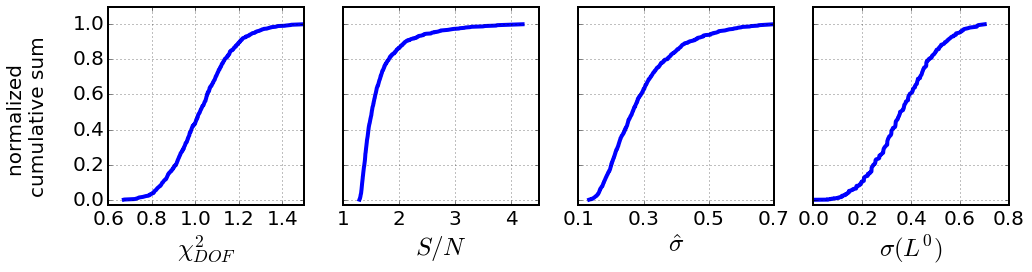

In [47]:
import gc ; gc.collect()


# choose which items should have their cumulative 
# distribution plotted... 
items = ['chi2dof', 'SN', 'pdf_mean_sigma', 'sigma_lnL_max']
labels = [r'$\chi^{2}_{DOF}$', r'$S/N$', r'$\hat{\sigma}$', r'$\sigma(L^{0})$']

fig,axs = plt.subplots(1,4,figsize=(14,4), sharey=True)
#fig.share
ax = np.ravel(axs)

for i in range(len(ax)):
    y = np.sort(null_stats[items[i]])
    # plot the cumulative sum ... 
    ax[i].plot(y,np.cumsum(y) / np.sum(y), lw=4)
    ax[i].set_xlabel(labels[i])
    ax[i].grid()
    
Ylabel = 'normalized \ncumulative sum'
fig.text(0.0, 0.55, Ylabel, ha='center', va='center', rotation='vertical',fontsize=20)


xticks = ax[0].get_xticks()
#ax[0].set_xticks(xticks[::2])

for i in [0,1,2,3]:
    xticks = ax[i].get_xticks()
    ax[i].set_xticks(xticks[::2])

plt.tight_layout()
fig.subplots_adjust( left=0.08, wspace=0.2)
ax[0].set_ylim(-0.03,1.1)

plt.savefig(outDir + 'Fig_null_test_cumsum.png', bbox_inches = 'tight')